# **Feature Engineering Notebook**

## Objectives

*   Engineer features for Classification, Regression and Cluster models


## Inputs

* inputs/datasets/cleaned/TrainSet.csv
* inputs/datasets/cleaned/TestSet.csv

## Outputs

* generate a list with variables to engineer

## Conclusions



* Feature Engineering Transformers
  * Ordinal categorical encoding: `['xxxxxxxxxxxxxfill in from the middle result', 'xxxxxxxxxxxxx', 'xxxxxxx']`
  * Smart Correlation Selection: `['xxxxxxxxxxxxxxxxxxx fill in from the bottom result', 'xxxxxxx', 'xxxxxxxx']`
  


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/data-driven-design/jupyter_notebooks'

We want to make the parent of the current directory the new current directory.
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/data-driven-design'

---

# Load Cleaned Data

Train Set

In [4]:
import pandas as pd
train_set_path = "outputs/datasets/cleaned/TrainSetCleaned.csv"
TrainSet = pd.read_csv(train_set_path)
TrainSet.head(3)

,Wing_Span,Length,Height,Multi_Engine,TP_mods,Engine_Type,AUW,MEW,FW,Vmax,...,Vstall,Range,Hmax,Hmax_(One),ROC,ROC_(One),Vlo,Slo,Vl,Sl
0,64.333333,68.416667,20.666667,True,False,2,48300.0,26985.0,20000.0,546.94,...,99.659388,4045.0,41000.0,20000.0,2512.569226,680.0,6969.145819,5684.0,3693.285251,2777.0
1,37.166667,31.166667,10.250000,True,False,0,5200.0,3229.0,964.8,220.00,...,59.000000,620.0,30000.0,18700.0,1530.000000,265.0,1250.000000,820.0,1250.000000,850.0
2,37.666667,25.583333,9.500000,True,False,0,4880.0,2960.0,750.4,200.00,...,66.000000,745.0,19200.0,7600.0,1630.000000,350.0,1700.000000,1255.0,1470.000000,1250.0


Test Set

In [5]:
test_set_path = 'outputs/datasets/cleaned/TestSetCleaned.csv'
TestSet = pd.read_csv(test_set_path)
TestSet.head(3)

,Wing_Span,Length,Height,Multi_Engine,TP_mods,Engine_Type,AUW,MEW,FW,Vmax,...,Vstall,Range,Hmax,Hmax_(One),ROC,ROC_(One),Vlo,Slo,Vl,Sl
0,32.750000,25.083333,6.500000,False,False,0,2650.0,1575.0,261.3,160.0,...,49.0,470.0,17100.0,17100.0,890.0,890.0,1515.0,1275.0,950.0,625.0
1,43.000000,30.083333,11.250000,False,False,1,4318.0,2900.0,1011.7,265.0,...,60.0,1000.0,27000.0,27000.0,3000.0,3000.0,1200.0,800.0,1000.0,800.0
2,44.083333,36.333333,11.416667,True,False,0,6850.0,4238.0,1427.1,230.0,...,68.0,875.0,26900.0,14800.0,1450.0,301.0,2195.0,1763.0,2485.0,1055.0


# Data Exploration

In feature engineering, you are interested to evaluate which potential transformation you could do in your variables
* Take your notes in your separate spreadsheet

In [6]:
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=TrainSet, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Correlation and PPS Analysis

* We don’t expect major changes compared to the data cleaning notebook since the only data difference is the removal of Meta Data and the two design parameters “THR” and “SHP”, so correlation levels and PPS will essentially be the same.

# Feature Engineering

## Custom function

We studied this custom function in the feature-engine lesson. That will help you with the feature engineering process.
* Do not worry if you need help understanding the full code at first, as it is expected you will take some time to absorb the use case.
* At this moment, what matters is to understand the function objective and how you can use it.

In [7]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like ydata-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                 f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


## Feature Engineering Spreadsheet Summary

* Consider the notes taken in your spreadsheet summary. List the transformers you will use
    * Categorical Encoding
    * Numerical Transformation
    * Smart Correlation Selection

* Categorical:
  * One-Hot Encoding: Creates binary columns for each category.
  * Label Encoding: Assigns a unique integer to each category.
  * Ordinal Encoding: Used for ordinal variables where the order matters.

* Categorical Encoding prepares categorical data for machine learning models.
* Numerical Transformation modifies numerical features to improve model performance.
* Smart Correlation Selection focuses on selecting the most relevant features based on their correlation with the target variable.

Maybe also do discretization and outliers (numerical encoding)

## Dealing with Feature Engineering

### Categorical Encoding - Ordinal: replaces categories with ordinal numbers 

In [8]:
TrainSet.head(3)

,Wing_Span,Length,Height,Multi_Engine,TP_mods,Engine_Type,AUW,MEW,FW,Vmax,...,Vstall,Range,Hmax,Hmax_(One),ROC,ROC_(One),Vlo,Slo,Vl,Sl
0,64.333333,68.416667,20.666667,True,False,2,48300.0,26985.0,20000.0,546.94,...,99.659388,4045.0,41000.0,20000.0,2512.569226,680.0,6969.145819,5684.0,3693.285251,2777.0
1,37.166667,31.166667,10.250000,True,False,0,5200.0,3229.0,964.8,220.00,...,59.000000,620.0,30000.0,18700.0,1530.000000,265.0,1250.000000,820.0,1250.000000,850.0
2,37.666667,25.583333,9.500000,True,False,0,4880.0,2960.0,750.4,200.00,...,66.000000,745.0,19200.0,7600.0,1630.000000,350.0,1700.000000,1255.0,1470.000000,1250.0


* Step 1: Select variable(s)

'Multi Engine' and 'TP mods' are both categorical values however we see in the previous pandas profiling that we need to convert their boolean "True" and "False" to numbers (1 and 0) so that the models can work with them. Engine Type is also a categorical values with three categories however this is already categorised into numbers (jet = 0, propjet = 1 and prop = 2)

In [9]:
variables_engineering= ['Multi_Engine','TP_mods']

variables_engineering

['Multi_Engine', 'TP_mods']

* Step 2: Create a separate DataFrame, with your variable(s)

Test if this %matplotlib inline

In [10]:
%matplotlib inline

In [11]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(3)

,Multi_Engine,TP_mods
0,True,False
1,True,False
2,True,False


* Step 3: Create engineered variables(s) by applying the transformation(s), assess engineered variables distribution and select the most suitable method for each variable.

XXXXXXXXXXXXXXXXXXXXXXXXXXXXX Why do I not get the other plots here that came for the Churnometer wlakthrough!? I tested with: %matplotlib inline

* Variable Analyzed: Multi_Engine
* Applied transformation: [] 



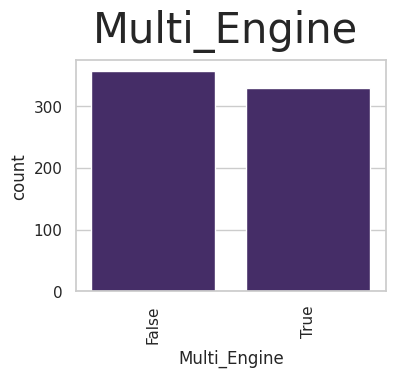





* Variable Analyzed: TP_mods
* Applied transformation: [] 



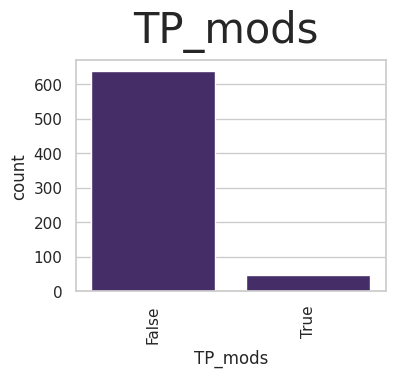

In [12]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='ordinal_encoder')

* We will balance the target variable Multi Engine since it is slightly unbalanced.
* TP models is highly unblanced however since we are not using this feature as a target variable we do not need to rebalance it.

* For each variable, write your conclusion on how the transformation(s) look(s) to be effective.
  * For all variables, the transformation is effective, since it converted categories to numbers.



* Step 4 - Apply the selected transformation to the Train and Test set

Convert bool to object to allow for the encoder (in the next step) to work. We choose object rather than "category" (which is a data type unique pandas)

In [13]:
for var in variables_engineering:
    TrainSet[var] = TrainSet[var].astype('object')
    TestSet[var] = TestSet[var].astype('object')


In [14]:
# the steps are: 
# 1 - create a transformer
# 2 - fit_transform into TrainSet
# 3 - transform into TestSet 
encoder = OrdinalEncoder(encoding_method='arbitrary', variables = variables_engineering)
TrainSet = encoder.fit_transform(TrainSet)
TestSet = encoder.transform(TestSet)

print("* Categorical encoding - ordinal transformation done!")

* Categorical encoding - ordinal transformation done!


In [15]:
data_types_TrainSet = TrainSet.dtypes
data_types_TestSet = TestSet.dtypes

print(data_types_TrainSet)
print(data_types_TestSet)


Wing_Span       float64
Length          float64
Height          float64
Multi_Engine      int64
TP_mods           int64
Engine_Type       int64
AUW             float64
MEW             float64
FW              float64
Vmax            float64
Vcruise         float64
Vstall          float64
Range           float64
Hmax            float64
Hmax_(One)      float64
ROC             float64
ROC_(One)       float64
Vlo             float64
Slo             float64
Vl              float64
Sl              float64
dtype: object
Wing_Span       float64
Length          float64
Height          float64
Multi_Engine      int64
TP_mods           int64
Engine_Type       int64
AUW             float64
MEW             float64
FW              float64
Vmax            float64
Vcruise         float64
Vstall          float64
Range           float64
Hmax            float64
Hmax_(One)      float64
ROC             float64
ROC_(One)       float64
Vlo             float64
Slo             float64
Vl              float64
Sl

### Balancing Categorical data

Comment on that it is mainly the target data that could be balanced since, although the data represent reallity, e.g. there are much more jet powered propulsion than propjet, you can still throw away some of the jet data to get equally many datapoints in both categories without changing reality. This however would not be the case with the features that are not target variables!

### Splitting Feature Engineering notebook into two: "4_feature_engineering_part_1" and "4_feature_engineering_part_2"

The size (many plots) of this notebook made it slow and difficult to scroll. For this reason it has been split into two separate notebooks. In the next notebook we will continue Feature Engineering with the "numerical transformation" and "smart correlation"

---

# Push featured Engineered (@ intermediate stage) data to Repo

In [16]:
import os
try:
  os.makedirs(name='outputs/datasets/feature_engineering') # outputs/datasets/feature_engineering
except Exception as e:
  print(e)


[Errno 17] File exists: 'outputs/datasets/feature_engineering'


## Train Set

In [17]:
TrainSet.to_csv("outputs/datasets/feature_engineering/TrainSet.csv", index=False)

## Test Set

In [18]:
TestSet.to_csv("outputs/datasets/feature_engineering/TestSet.csv", index=False)